<a href="https://colab.research.google.com/github/CarlosGOspino/ML-Projects/blob/master/Predicting_ocupations_type_from_ratings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This notebook uses O*NET skill level and importance ratings to predict whether an occupation is Cogntive.
I will use the h2o modeling environment to carry out his analysis. The motivation is taking advantage of the computing power in Colab to find the best performing model.

In [0]:
#install the necesary modules
! apt-get install default-jre
!java -version
! pip install h2o

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
default-jre set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
openjdk version "11.0.6" 2020-01-14
OpenJDK Runtime Environment (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1)
OpenJDK 64-Bit Server VM (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1, mixed mode, sharing)
     |████████████████████████████████| 126.2MB 42kB/s 
  Created wheel for h2o: filename=h2o-3.28.0.3-py2.py3-none-any.whl size=126303006 sha256=49f42baddb96d846ea3514c42f332635c5d765edeb7ac21d722e5329de19d610
  Stored in directory: /root/.cache/pip/wheels/fa/7c/ce/95ae52b4d3f1b14a27c3c961c1f94635aee841ab1eec3aeeca
Successfully built h2o


In [0]:
#Import necesary libraries
import os
from pathlib import Path
import h2o

In [0]:
#Create a data folder
!ls
!mkdir data

sample_data


In [0]:
#make the data folder the current working directory
os.chdir('data')
data_dir=Path(os.getcwd())
!ls

In [0]:
#Get the data from O*NET's site
import urllib.request

print('Beginning file download with urllib2...')

url = 'https://www.onetcenter.org/dl_files/database/db_24_1_text.zip'
urllib.request.urlretrieve(url, data_dir / 'db_24_1_text.zip')

Beginning file download with urllib2...


(PosixPath('/content/data/db_24_1_text.zip'),
 <http.client.HTTPMessage at 0x7f672938b518>)

In [0]:
#Unzip the files to the current working directory
import zipfile
with zipfile.ZipFile(os.getcwd()+'/db_24_1_text.zip', 'r') as zip_ref:
    zip_ref.extractall(os.getcwd())

In [0]:
#view the contents of the dowloaded files
!ls db_24_1_text/

 Abilities.txt
'Alternate Titles.txt'
'Career Changers Matrix.txt'
'Career Starters Matrix.txt'
'Content Model Reference.txt'
'DWA Reference.txt'
'Education, Training, and Experience Categories.txt'
'Education, Training, and Experience.txt'
'Emerging Tasks.txt'
'Green DWA Reference.txt'
'Green Occupations.txt'
'Green Task Statements.txt'
 Interests.txt
'IWA Reference.txt'
'Job Zone Reference.txt'
'Job Zones.txt'
 Knowledge.txt
'Level Scale Anchors.txt'
'Occupation Data.txt'
'Occupation Level Metadata.txt'
'Read Me.txt'
'Sample of Reported Titles.txt'
'Scales Reference.txt'
 Skills.txt
'Survey Booklet Locations.txt'
'Task Categories.txt'
'Task Ratings.txt'
'Task Statements.txt'
'Tasks to DWAs.txt'
'Tasks to Green DWAs.txt'
'Technology Skills.txt'
'Tools and Technology.txt'
'Tools Used.txt'
'UNSPSC Reference.txt'
'Work Activities.txt'
'Work Context Categories.txt'
'Work Context.txt'
'Work Styles.txt'
'Work Values.txt'


In [0]:
#import data manipulation libraries
import pandas as pd
import numpy as np
import glob
#Create dictionary of task files
os.chdir(data_dir / 'db_24_1_text')
task_df={file:pd.read_csv(file, sep='\t') for file in glob.glob("Task*.txt")}
abilities_df=pd.read_csv('Abilities.txt', sep='\t')

## O*NET description of cognitive skills
- Category Flexibility — The ability to generate or use different sets of rules for combining or grouping things in different ways.
- Deductive Reasoning — The ability to apply general rules to specific problems to produce answers that make sense.
- Flexibility of Closure — The ability to identify or detect a known pattern (a figure, object, word, or sound) that is hidden in other distracting material.
- Fluency of Ideas — The ability to come up with a number of ideas about a topic (the number of ideas is important, not their quality, correctness, or creativity).
- Inductive Reasoning — The ability to combine pieces of information to form general rules or conclusions (includes finding a relationship among seemingly unrelated events).
- Information Ordering — The ability to arrange things or actions in a certain order or pattern according to a specific rule or set of rules (e.g., patterns of numbers, letters, words, pictures, mathematical operations).
- Mathematical Reasoning — The ability to choose the right mathematical methods or formulas to solve a problem.
- Memorization — The ability to remember information such as words, numbers, pictures, and procedures.
- Number Facility — The ability to add, subtract, multiply, or divide quickly and correctly.
- Oral Comprehension — The ability to listen to and understand information and ideas presented through spoken words and sentences.
- Oral Expression — The ability to communicate information and ideas in speaking so others will understand.
- Originality — The ability to come up with unusual or clever ideas about a given topic or situation, or to develop creative ways to solve a problem.
- Perceptual Speed — The ability to quickly and accurately compare similarities and differences among sets of letters, numbers, objects, pictures, or patterns. The things to be compared may be presented at the same time or one after the other. This ability also includes comparing a presented object with a remembered object.
- Problem Sensitivity — The ability to tell when something is wrong or is likely to go wrong. It does not involve solving the problem, only recognizing there is a problem.
- Selective Attention — The ability to concentrate on a task over a period of time without being distracted.
- Spatial Orientation — The ability to know your location in relation to the environment or to know where other objects are in relation to you.
- Speed of Closure — The ability to quickly make sense of, combine, and organize information into meaningful patterns.
- Time Sharing — The ability to shift back and forth between two or more activities or sources of information (such as speech, sounds, touch, or other sources).
- Visualization — The ability to imagine how something will look after it is moved around or when its parts are moved or rearranged.
- Written Comprehension — The ability to read and understand information and ideas presented in writing.
- Written Expression — The ability to communicate information and ideas in writing so others will understand.


In [0]:
# Filter skills dataframe to keep only cognitive skills according to previous cell definitions.
# Task ratings need to be standardized see (https://www.onetonline.org/help/online/scales#score)
# Select a list of Cognitive abilities from (https://www.onetonline.org/find/descriptor/browse/Abilities/1.A.1/), standardize and calculate the median per occupation.
# I need some kind of criteria to assign to ANALYTICAL. Something along the lines of above the median.
cognitive_skills=['Category Flexibility', 'Deductive Reasoning', 'Flexibility of Closure','Fluency of Ideas', 
                  'Inductive Reasoning', 'Information Ordering', 'Mathematical Reasoning', 'Memorization' , 
                  'Number Facility', 'Oral Comprehension', 'Oral Expression', 'Originality', 'Perceptual Speed',
                  'Problem Sensitivity', 'Selective Attention', 'Spatial Orientation', 'Speed of Closure',
                  'Time Sharing', 'Visualization', 'Written Comprehension', 'Written Expression']
cognitive_skills_df=abilities_df[abilities_df['Element Name'].isin(cognitive_skills)]
cognitive_skills_df.head()

,O*NET-SOC Code,Element ID,Element Name,Scale ID,Data Value,N,Standard Error,Lower CI Bound,Upper CI Bound,Recommend Suppress,Not Relevant,Date,Domain Source
0,11-1011.00,1.A.1.a.1,Oral Comprehension,IM,4.50,8.0,0.19,4.13,4.87,N,NaN,07/2014,Analyst
1,11-1011.00,1.A.1.a.1,Oral Comprehension,LV,4.88,8.0,0.13,4.63,5.12,N,N,07/2014,Analyst
2,11-1011.00,1.A.1.a.2,Written Comprehension,IM,4.25,8.0,0.16,3.93,4.57,N,NaN,07/2014,Analyst
3,11-1011.00,1.A.1.a.2,Written Comprehension,LV,4.62,8.0,0.18,4.27,4.98,N,N,07/2014,Analyst
4,11-1011.00,1.A.1.a.3,Oral Expression,IM,4.38,8.0,0.18,4.02,4.73,N,NaN,07/2014,Analyst


In [0]:
# Reorganize the DataFrame to have one occupation per observation.
# Reindex the DataFrame
columns=['O*NET-SOC Code',	'Element Name',	'Scale ID',	'Data Value']
df=cognitive_skills_df.loc[:,columns]
df=df.set_index(['O*NET-SOC Code', 'Element Name', 'Scale ID'])
df=df.unstack().unstack()
df.describe()

Data Value  ...                   
Scale ID                       IM  ...                 LV
Element Name Category Flexibility  ... Written Expression
count                  968.000000  ...         968.000000
mean                     3.119246  ...           3.404494
std                      0.320686  ...           0.898003
min                      1.880000  ...           1.000000
25%                      3.000000  ...           2.750000
50%                      3.120000  ...           3.620000
75%                      3.250000  ...           4.000000
max                      4.000000  ...           5.630000

[8 rows x 42 columns]

In [0]:
#Create a scaling function to standardize ratings
def scaler(v, min, max):
  '"This function stardizes O*NET Imporance and level ratings."'
  '"It takes as inputs the variable to standardize, the minimum and maximum value"'
  return ( (v - min) / (max - min) ) * 100

In [0]:
#use multi index slicer
idx = pd.IndexSlice
#standardize ratings (0-100) using previously constructed scaler.
IM=df.loc[:, idx[:, ['IM'],:]].apply(lambda x: scaler(x, 1, 5), axis=0)
LV=df.loc[:, idx[:, ['LV'],:]].apply(lambda x: scaler(x, 0, 7), axis=0)
#Calculate each occupation's median ratings.
IM['IM_median']=IM.loc[:, idx[:, ['IM'],:]].apply(np.median, axis=1)
LV['LV_median']=LV.loc[:, idx[:, ['LV'],:]].apply(np.median, axis=1)
print(IM['IM_median'].head(), LV['LV_median'].head())
#Calculate all occupation's median ratings.
IM_MASK=IM['IM_median']>np.median(IM['IM_median'])
LV_MASK=LV['LV_median']>np.median(LV['LV_median'])


O*NET-SOC Code
11-1011.00    62.50
11-1011.03    59.50
11-1021.00    50.00
11-2011.00    56.25
11-2021.00    56.25
Name: IM_median, dtype: float64 O*NET-SOC Code
11-1011.00    58.857143
11-1011.03    51.714286
11-1021.00    44.571429
11-2011.00    53.571429
11-2021.00    51.714286
Name: LV_median, dtype: float64


In [0]:
df_clean=pd.concat([IM, LV], axis=1)
df_clean['Analytical']=IM_MASK & LV_MASK
df_clean.drop(['IM_median', 'LV_median'], axis=1, inplace=True)
df_clean.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


Data Value  ... Analytical
Scale ID                         IM  ...           
Element Name   Category Flexibility  ...           
O*NET-SOC Code                       ...           
11-1011.00                    62.50  ...       True
11-1011.03                    59.50  ...       True
11-1021.00                    50.00  ...      False
11-2011.00                    59.50  ...       True
11-2021.00                    56.25  ...       True

[5 rows x 43 columns]

In [0]:
# Instatiate an h2o machine
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.6" 2020-01-14; OpenJDK Runtime Environment (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1); OpenJDK 64-Bit Server VM (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpjnk9qqe0
  JVM stdout: /tmp/tmpjnk9qqe0/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpjnk9qqe0/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.3
H2O cluster version age:,16 days
H2O cluster name:,H2O_from_python_unknownUser_koo3zm
H2O cluster total nodes:,1
H2O cluster free memory:,2.938 Gb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"accepting new members, healthy"


In [0]:
#import h2o libraries for AutoML and leaderboards
from h2o.automl import H2OAutoML, get_leaderboard
#create an h2o dataframe
data=h2o.H2OFrame(df_clean.reset_index())
#Create test/test split for ML training
train, test =data.split_frame(ratios=[.8], seed=1111)
#name features for further analysis of results
train.set_names([' '.join(col).strip() for col in df_clean.reset_index().columns.values])
test.set_names([' '.join(col).strip() for col in df_clean.reset_index().columns.values])

Parse progress: |█████████████████████████████████████████████████████████| 100%


O*NET-SOC Code,Data Value IM Category Flexibility,Data Value IM Deductive Reasoning,Data Value IM Flexibility of Closure,Data Value IM Fluency of Ideas,Data Value IM Inductive Reasoning,Data Value IM Information Ordering,Data Value IM Mathematical Reasoning,Data Value IM Memorization,Data Value IM Number Facility,Data Value IM Oral Comprehension,Data Value IM Oral Expression,Data Value IM Originality,Data Value IM Perceptual Speed,Data Value IM Problem Sensitivity,Data Value IM Selective Attention,Data Value IM Spatial Orientation,Data Value IM Speed of Closure,Data Value IM Time Sharing,Data Value IM Visualization,Data Value IM Written Comprehension,Data Value IM Written Expression,Data Value LV Category Flexibility,Data Value LV Deductive Reasoning,Data Value LV Flexibility of Closure,Data Value LV Fluency of Ideas,Data Value LV Inductive Reasoning,Data Value LV Information Ordering,Data Value LV Mathematical Reasoning,Data Value LV Memorization,Data Value LV Number Facility,Data Value LV Oral Comprehension,Data Value LV Oral Expression,Data Value LV Originality,Data Value LV Perceptual Speed,Data Value LV Problem Sensitivity,Data Value LV Selective Attention,Data Value LV Spatial Orientation,Data Value LV Speed of Closure,Data Value LV Time Sharing,Data Value LV Visualization,Data Value LV Written Comprehension,Data Value LV Written Expression,Analytical
11-1011.03,59.5,75,50,65.5,75,62.5,47,31.25,43.75,75,75,65.5,34.5,72,47,6.25,34.5,40.5,43.75,75,72,51.7143,64.2857,42.8571,58.8571,60.7143,51.7143,46.4286,35.7143,46.4286,64.2857,66,57.1429,34,60.7143,39.2857,3.57143,37.4286,34,44.5714,62.5714,62.5714,True
11-3051.02,56.25,75,53,50,72,62.5,56.25,37.5,53,78,78,47,50,75,50,25,40.5,43.75,50,65.5,65.5,50,57.1429,44.5714,48.2857,48.2857,51.7143,53.5714,37.4286,50,62.5714,60.7143,46.4286,46.4286,58.8571,46.4286,25,39.2857,35.7143,42.8571,58.8571,53.5714,True
11-3071.01,56.25,75,50,59.5,72,62.5,50,31.25,53,75,75,56.25,43.75,75,47,9.5,37.5,47,34.5,75,75,48.2857,58.8571,41.1429,53.5714,53.5714,55.4286,42.8571,34,42.8571,60.7143,60.7143,50,37.4286,57.1429,41.1429,7.14286,34,32.1429,37.4286,60.7143,57.1429,True
11-9039.01,56.25,72,37.5,65.5,72,65.5,47,34.5,40.5,78,78,56.25,37.5,75,50,0,34.5,34.5,40.5,72,75,48.2857,62.5714,37.4286,53.5714,55.4286,50,44.5714,34,41.1429,62.5714,60.7143,51.7143,35.7143,51.7143,39.2857,0,30.2857,32.1429,37.4286,62.5714,62.5714,True
11-9071.00,56.25,75,53,47,72,59.5,50,47,53,75,75,43.75,53,72,56.25,6.25,50,53,34.5,65.5,62.5,46.4286,57.1429,46.4286,42.8571,55.4286,51.7143,44.5714,42.8571,46.4286,57.1429,57.1429,42.8571,44.5714,55.4286,53.5714,3.57143,42.8571,44.5714,30.2857,55.4286,51.7143,True
11-9199.07,56.25,75,47,59.5,75,62.5,37.5,40.5,34.5,78,78,56.25,43.75,78,56.25,28,50,40.5,40.5,72,72,50,62.5714,44.5714,51.7143,58.8571,53.5714,39.2857,37.4286,37.4286,60.7143,60.7143,51.7143,41.1429,62.5714,46.4286,26.8571,46.4286,37.4286,41.1429,57.1429,58.8571,True
13-1011.00,50,68.75,34.5,56.25,65.75,56.25,43.75,31.25,40.75,84.5,84.5,56.25,18.75,75,50,0,31.25,40.75,37.5,75,72,41.1429,53.5714,28.5714,48.2857,55.4286,42.8571,42.8571,26.8571,37.5714,57.1429,59,46.4286,23.2857,53.5714,37.5714,0,26.8571,35.7143,32.1429,57.1429,55.4286,False
13-1023.00,53,68.75,34.5,50,68.75,68.75,53,37.5,53,75,72,50,31.25,68.75,47,0,31.25,40.5,25,78,72,46.4286,57.1429,32.1429,42.8571,55.4286,53.5714,46.4286,39.2857,44.5714,57.1429,57.1429,42.8571,32.1429,55.4286,42.8571,0,37.4286,37.4286,26.8571,57.1429,55.4286,True
13-1031.02,53,75,53,43.75,75,62.5,53,25,53,75,75,40.5,50,62.5,47,12.5,50,25,47,75,65.5,46.4286,57.1429,44.5714,39.2857,57.1429,48.2857,51.7143,26.8571,51.7143,57.1429,57.1429,32.1429,42.8571,48.2857,41.1429,8.85714,42.8571,25,42.8571,57.1429,55.4286,True
13-1161.00,68.75,75,50,75,78,72,59.5,43.75,53,75,75,59.5,43.75,65.5,47,0,37.5,34.5,34.5,75,75,53.5714,62.5714,46.4286,57.1429,60.7143,55.4286,55.4286,39.2857,53.5714,64.2857,64.2857,48.2857,41.1429,55.4286,41.1429,0,39.2857,32.1429,37.4286,64.2857,64.2857,True


In [0]:

data.set_names([' '.join(col).strip() for col in df_clean.reset_index().columns.values])

O*NET-SOC Code,Data Value IM Category Flexibility,Data Value IM Deductive Reasoning,Data Value IM Flexibility of Closure,Data Value IM Fluency of Ideas,Data Value IM Inductive Reasoning,Data Value IM Information Ordering,Data Value IM Mathematical Reasoning,Data Value IM Memorization,Data Value IM Number Facility,Data Value IM Oral Comprehension,Data Value IM Oral Expression,Data Value IM Originality,Data Value IM Perceptual Speed,Data Value IM Problem Sensitivity,Data Value IM Selective Attention,Data Value IM Spatial Orientation,Data Value IM Speed of Closure,Data Value IM Time Sharing,Data Value IM Visualization,Data Value IM Written Comprehension,Data Value IM Written Expression,Data Value LV Category Flexibility,Data Value LV Deductive Reasoning,Data Value LV Flexibility of Closure,Data Value LV Fluency of Ideas,Data Value LV Inductive Reasoning,Data Value LV Information Ordering,Data Value LV Mathematical Reasoning,Data Value LV Memorization,Data Value LV Number Facility,Data Value LV Oral Comprehension,Data Value LV Oral Expression,Data Value LV Originality,Data Value LV Perceptual Speed,Data Value LV Problem Sensitivity,Data Value LV Selective Attention,Data Value LV Spatial Orientation,Data Value LV Speed of Closure,Data Value LV Time Sharing,Data Value LV Visualization,Data Value LV Written Comprehension,Data Value LV Written Expression,Analytical
11-1011.00,62.5,78,59.5,72,75,65.5,59.5,50,56.25,87.5,84.5,72,53,75,50,3,53,50,53,81.25,78,58.8571,71.4286,50,66,71.4286,57.1429,55.4286,44.5714,58.8571,69.7143,71.4286,60.7143,41.1429,71.4286,44.5714,1.71429,48.2857,41.1429,55.4286,66,66,True
11-1011.03,59.5,75,50,65.5,75,62.5,47,31.25,43.75,75,75,65.5,34.5,72,47,6.25,34.5,40.5,43.75,75,72,51.7143,64.2857,42.8571,58.8571,60.7143,51.7143,46.4286,35.7143,46.4286,64.2857,66,57.1429,34,60.7143,39.2857,3.57143,37.4286,34,44.5714,62.5714,62.5714,True
11-1021.00,50,68.75,43.75,50,53,62.5,47,28,43.75,75,75,50,40.5,75,50,12.5,31.25,47,43.75,75,75,42.8571,53.5714,32.1429,46.4286,48.2857,51.7143,44.5714,32.1429,37.4286,58.8571,57.1429,48.2857,32.1429,55.4286,41.1429,8.85714,30.2857,41.1429,35.7143,57.1429,57.1429,False
11-2011.00,59.5,72,53,68.75,62.5,56.25,50,37.5,47,75,81.25,68.75,47,65.5,47,0,40.5,43.75,56.25,75,72,55.4286,64.2857,44.5714,58.8571,55.4286,53.5714,44.5714,34,44.5714,62.5714,67.8571,55.4286,39.2857,57.1429,39.2857,0,39.2857,30.2857,44.5714,57.1429,57.1429,True
11-2021.00,56.25,72,50,68.75,68.75,56.25,53,40.5,53,75,75,65.5,43.75,65.5,47,0,43.75,43.75,50,75,72,51.7143,62.5714,42.8571,60.7143,55.4286,50,51.7143,42.8571,50,62.5714,58.8571,57.1429,41.1429,55.4286,41.1429,0,42.8571,37.4286,42.8571,58.8571,58.8571,True
11-2022.00,56.25,72,43.75,68.75,68.75,59.5,53,50,53,75,75,65.5,37.5,68.75,40.5,12.5,43.75,40.5,34.5,75,72,51.7143,62.5714,39.2857,53.5714,57.1429,48.2857,53.5714,42.8571,51.7143,64.2857,58.8571,55.4286,34,55.4286,37.4286,7.14286,42.8571,34,35.7143,57.1429,57.1429,True
11-2031.00,56.25,72,43.75,75,72,65.5,43.75,40.5,47,75,81.25,65.5,34.5,72,47,0,43.75,47,47,75,78,48.2857,58.8571,39.2857,58.8571,53.5714,51.7143,42.8571,39.2857,42.8571,64.2857,67.8571,57.1429,34,57.1429,41.1429,0,39.2857,39.2857,39.2857,58.8571,66,True
11-3011.00,53,65.5,47,53,62.5,53,40.5,40.5,43.75,75,75,50,43.75,62.5,53,12.5,28,53,47,75,72,44.5714,55.4286,34,44.5714,48.2857,44.5714,35.7143,37.4286,39.2857,57.1429,57.1429,44.5714,34,53.5714,42.8571,7.14286,37.4286,41.1429,39.2857,57.1429,57.1429,True
11-3021.00,56.25,75,50,59.5,75,68.75,50,40.5,53,75,75,56.25,43.75,75,47,3,43.75,40.5,50,75,68.75,44.5714,57.1429,42.8571,53.5714,57.1429,57.1429,42.8571,37.4286,44.5714,64.2857,62.5714,50,39.2857,57.1429,41.1429,1.71429,39.2857,30.2857,42.8571,62.5714,58.8571,True
11-3031.01,62.5,78,50,53,78,68.75,72,43.75,68.75,75,75,53,50,75,43.75,0,53,37.5,40.5,75,72,51.7143,64.2857,44.5714,51.7143,58.8571,55.4286,60.7143,39.2857,62.5714,60.7143,66,48.2857,42.8571,67.8571,39.2857,0,44.5714,30.2857,39.2857,62.5714,58.8571,True


In [0]:
# Identify predictors and response
x = train.columns
y = "Analytical"
x.remove(y)
x.remove('O*NET-SOC Code')

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, seed=1111)
aml.train(x=x, y=y, training_frame=train)

# AutoML Leaderboard
lb = aml.leaderboard

# Optionally edd extra model information to the leaderboard
lb = get_leaderboard(aml, extra_columns='ALL')

# Print all rows (instead of default 10 rows)
lb.head(rows=lb.nrows)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms
XGBoost_3_AutoML_20200221_182130,0.987973,0.140878,0.972576,0.0600027,0.20954,0.043907,1266,0.020806
XGBoost_grid__1_AutoML_20200221_182130_model_4,0.987885,0.143027,0.981361,0.0609413,0.208764,0.0435826,1407,0.023381
XGBoost_grid__1_AutoML_20200221_182130_model_1,0.987024,0.150688,0.977018,0.0578372,0.213435,0.0455546,1057,0.013776
GBM_2_AutoML_20200221_182130,0.985981,0.156061,0.969878,0.0665929,0.219841,0.04833,684,0.033217
XGBoost_grid__1_AutoML_20200221_182130_model_3,0.985898,0.155567,0.972871,0.0648364,0.219045,0.0479809,1504,0.012505
XGBoost_1_AutoML_20200221_182130,0.985844,0.155228,0.972498,0.0688053,0.217715,0.0473997,1377,0.010001
GBM_5_AutoML_20200221_182130,0.98568,0.152823,0.960277,0.0643805,0.215945,0.0466321,682,0.020297
StackedEnsemble_BestOfFamily_AutoML_20200221_182130,0.985673,0.171392,0.969386,0.0668812,0.223906,0.0501338,304,0.081779
GBM_3_AutoML_20200221_182130,0.98563,0.156421,0.969266,0.0609882,0.21904,0.0479786,834,0.020877
StackedEnsemble_AllModels_AutoML_20200221_182130,0.985579,0.169768,0.966114,0.0649571,0.221058,0.0488667,505,0.346855


In [0]:
aml.leader

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20200221_182130


Model Summary: 


,,number_of_trees
0,,170.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.0070852068793188
RMSE: 0.08417367093883217
LogLoss: 0.04304204720576015
Mean Per-Class Error: 0.0011061946902655162
AUC: 0.9999932957897559
AUCPR: 0.9969605281044446
Gini: 0.9999865915795119

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5383245944976807: 


,,False,True,Error,Rate
0,False,451.0,1.0,0.0022,(1.0/452.0)
1,True,0.0,330.0,0.0,(0.0/330.0)
2,Total,451.0,331.0,0.0013,(1.0/782.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.538325,0.998487,199.0
1,max f2,0.538325,0.999394,199.0
2,max f0point5,0.567913,0.999392,197.0
3,max accuracy,0.567913,0.998721,197.0
4,max precision,0.998967,1.000000,0.0
5,max recall,0.538325,1.000000,199.0
6,max specificity,0.998967,1.000000,0.0
7,max absolute_mcc,0.538325,0.997383,199.0
8,max min_per_class_accuracy,0.538325,0.997788,199.0
9,max mean_per_class_accuracy,0.538325,0.998894,199.0



Gains/Lift Table: Avg response rate: 42.20 %, avg score: 42.18 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010230,0.998782,2.369697,2.369697,1.000000,0.998838,1.000000,0.998838,0.024242,0.024242,136.969697,136.969697
1,,2,0.020460,0.998676,2.369697,2.369697,1.000000,0.998735,1.000000,0.998787,0.024242,0.048485,136.969697,136.969697
2,,3,0.030691,0.998609,2.369697,2.369697,1.000000,0.998642,1.000000,0.998739,0.024242,0.072727,136.969697,136.969697
3,,4,0.040921,0.998516,2.369697,2.369697,1.000000,0.998563,1.000000,0.998695,0.024242,0.096970,136.969697,136.969697
4,,5,0.051151,0.998233,2.369697,2.369697,1.000000,0.998340,1.000000,0.998624,0.024242,0.121212,136.969697,136.969697
5,,6,0.101023,0.996811,2.369697,2.369697,1.000000,0.997633,1.000000,0.998135,0.118182,0.239394,136.969697,136.969697
6,,7,0.150895,0.994472,2.369697,2.369697,1.000000,0.995642,1.000000,0.997311,0.118182,0.357576,136.969697,136.969697
7,,8,0.200767,0.989839,2.369697,2.369697,1.000000,0.992152,1.000000,0.996029,0.118182,0.475758,136.969697,136.969697
8,,9,0.300512,0.963496,2.369697,2.369697,1.000000,0.980049,1.000000,0.990725,0.236364,0.712121,136.969697,136.969697
9,,10,0.400256,0.760407,2.369697,2.369697,1.000000,0.899392,1.000000,0.967965,0.236364,0.948485,136.969697,136.969697




ModelMetricsBinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.04390701543517377
RMSE: 0.20954000915141188
LogLoss: 0.14087750981191732
Mean Per-Class Error: 0.060002681684097614
AUC: 0.9879726468222043
AUCPR: 0.9725763701235682
Gini: 0.9759452936444086

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5009042620658875: 


,,False,True,Error,Rate
0,False,432.0,20.0,0.0442,(20.0/452.0)
1,True,25.0,305.0,0.0758,(25.0/330.0)
2,Total,457.0,325.0,0.0575,(45.0/782.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.500904,0.931298,194.0
1,max f2,0.190848,0.947616,245.0
2,max f0point5,0.704792,0.954425,165.0
3,max accuracy,0.534736,0.942455,192.0
4,max precision,0.999183,1.000000,0.0
5,max recall,0.057532,1.000000,292.0
6,max specificity,0.999183,1.000000,0.0
7,max absolute_mcc,0.500904,0.881874,194.0
8,max min_per_class_accuracy,0.424393,0.935841,207.0
9,max mean_per_class_accuracy,0.500904,0.939997,194.0



Gains/Lift Table: Avg response rate: 42.20 %, avg score: 41.97 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010230,0.998602,2.369697,2.369697,1.000000,0.998987,1.000000,0.998987,0.024242,0.024242,136.969697,136.969697
1,,2,0.020460,0.998177,2.369697,2.369697,1.000000,0.998382,1.000000,0.998684,0.024242,0.048485,136.969697,136.969697
2,,3,0.030691,0.997996,2.369697,2.369697,1.000000,0.998069,1.000000,0.998479,0.024242,0.072727,136.969697,136.969697
3,,4,0.040921,0.997761,2.369697,2.369697,1.000000,0.997845,1.000000,0.998320,0.024242,0.096970,136.969697,136.969697
4,,5,0.051151,0.997619,2.369697,2.369697,1.000000,0.997682,1.000000,0.998193,0.024242,0.121212,136.969697,136.969697
5,,6,0.101023,0.995451,2.369697,2.369697,1.000000,0.996720,1.000000,0.997466,0.118182,0.239394,136.969697,136.969697
6,,7,0.150895,0.992228,2.369697,2.369697,1.000000,0.993991,1.000000,0.996317,0.118182,0.357576,136.969697,136.969697
7,,8,0.200767,0.986420,2.369697,2.369697,1.000000,0.989294,1.000000,0.994572,0.118182,0.475758,136.969697,136.969697
8,,9,0.300512,0.936430,2.339316,2.359613,0.987179,0.969171,0.995745,0.986141,0.233333,0.709091,133.931624,135.961315
9,,10,0.400256,0.608529,1.913986,2.248562,0.807692,0.814515,0.948882,0.943372,0.190909,0.900000,91.398601,124.856230




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.9488486,0.0101242075,0.955414,0.9426752,0.9358974,0.96153843,0.94871795
1,auc,0.98830205,0.003268701,0.98817736,0.9871117,0.98532236,0.9938556,0.9870432
2,aucpr,0.96960044,0.005910232,0.9716608,0.97046417,0.9594546,0.97490215,0.97152036
3,err,0.051151395,0.0101242075,0.044585988,0.05732484,0.06410257,0.03846154,0.051282052
4,err_count,8.0,1.5811388,7.0,9.0,10.0,6.0,8.0
5,f0point5,0.9360262,0.024126166,0.9392265,0.94512194,0.90032154,0.9292035,0.9662577
6,f1,0.9392513,0.014767452,0.951049,0.93233085,0.91803277,0.95454544,0.9402985
7,f2,0.943303,0.028269893,0.9631728,0.9198813,0.93645483,0.9813084,0.9156977
8,lift_top_group,2.3801022,0.17733388,2.2428572,2.3088236,2.6440678,2.4761906,2.2285714
9,logloss,0.14085773,0.017308902,0.14527446,0.15191294,0.14771937,0.1101949,0.14918694



See the whole table with table.as_data_frame()

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2020-02-21 18:22:09,9.564 sec,0.0,0.500000,0.693147,0.500000,0.000000,1.000000,0.578005
1,,2020-02-21 18:22:09,9.628 sec,5.0,0.419799,0.543704,0.987768,0.619734,2.369697,0.057545
2,,2020-02-21 18:22:09,9.660 sec,10.0,0.357707,0.439319,0.992196,0.692482,2.369697,0.039642
3,,2020-02-21 18:22:09,9.691 sec,15.0,0.310598,0.363832,0.993711,0.721995,2.369697,0.034527
4,,2020-02-21 18:22:09,9.722 sec,20.0,0.274934,0.307637,0.994781,0.799253,2.369697,0.030691
5,,2020-02-21 18:22:09,9.750 sec,25.0,0.247339,0.264165,0.995505,0.954745,2.369697,0.031969
6,,2020-02-21 18:22:09,9.778 sec,30.0,0.226365,0.230211,0.996024,0.958398,2.369697,0.028133
7,,2020-02-21 18:22:09,9.807 sec,35.0,0.208360,0.201509,0.996655,0.959188,2.369697,0.025575
8,,2020-02-21 18:22:09,9.836 sec,40.0,0.193671,0.177950,0.997308,0.960007,2.369697,0.023018
9,,2020-02-21 18:22:09,9.870 sec,45.0,0.181104,0.158287,0.997731,0.972681,2.369697,0.019182



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,DataValueLVDeductiveReasoning,1616.101685,1.000000,0.187806
1,DataValueIMCategoryFlexibility,743.907288,0.460310,0.086449
2,DataValueIMDeductiveReasoning,741.646790,0.458911,0.086186
3,DataValueLVFlexibilityofClosure,519.127197,0.321222,0.060327
4,DataValueLVCategoryFlexibility,424.489929,0.262663,0.049330
5,DataValueLVInductiveReasoning,411.165466,0.254418,0.047781
6,DataValueIMFluencyofIdeas,399.034576,0.246912,0.046372
7,DataValueIMOriginality,393.717255,0.243622,0.045754
8,DataValueIMFlexibilityofClosure,233.776077,0.144654,0.027167
9,DataValueIMInductiveReasoning,222.652161,0.137771,0.025874



See the whole table with table.as_data_frame()


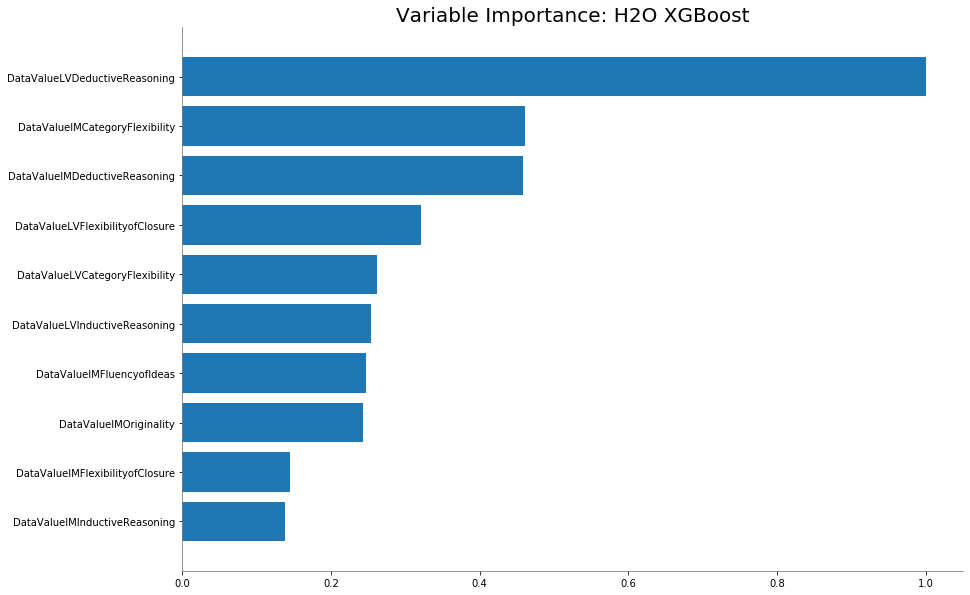

In [0]:
# build the variable importances plot:
aml.leader.varimp_plot()

In [0]:
# retrieve the model performance on the test dataset
perf = aml.leader.model_performance(test)
perf


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.023216212859188675
RMSE: 0.15236867414002353
LogLoss: 0.08728380779039908
Mean Per-Class Error: 0.01680672268907557
AUC: 0.9983694970525523
AUCPR: 0.982249546384466
Gini: 0.9967389941051046

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47378966212272644: 


,,False,True,Error,Rate
0,False,115.0,4.0,0.0336,(4.0/119.0)
1,True,0.0,67.0,0.0,(0.0/67.0)
2,Total,115.0,71.0,0.0215,(4.0/186.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.473790,0.971014,70.0
1,max f2,0.473790,0.988201,70.0
2,max f0point5,0.747978,0.987461,62.0
3,max accuracy,0.747978,0.978495,62.0
4,max precision,0.998714,1.000000,0.0
5,max recall,0.473790,1.000000,70.0
6,max specificity,0.998714,1.000000,0.0
7,max absolute_mcc,0.473790,0.954957,70.0
8,max min_per_class_accuracy,0.578964,0.970149,67.0
9,max mean_per_class_accuracy,0.473790,0.983193,70.0



Gains/Lift Table: Avg response rate: 36.02 %, avg score: 37.98 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010753,0.998568,2.776119,2.776119,1.000000,0.998667,1.000000,0.998667,0.029851,0.029851,177.611940,177.611940
1,,2,0.021505,0.998505,2.776119,2.776119,1.000000,0.998532,1.000000,0.998600,0.029851,0.059701,177.611940,177.611940
2,,3,0.032258,0.998046,2.776119,2.776119,1.000000,0.998357,1.000000,0.998519,0.029851,0.089552,177.611940,177.611940
3,,4,0.043011,0.997688,2.776119,2.776119,1.000000,0.997828,1.000000,0.998346,0.029851,0.119403,177.611940,177.611940
4,,5,0.053763,0.997532,2.776119,2.776119,1.000000,0.997588,1.000000,0.998195,0.029851,0.149254,177.611940,177.611940
5,,6,0.102151,0.993831,2.776119,2.776119,1.000000,0.995900,1.000000,0.997108,0.134328,0.283582,177.611940,177.611940
6,,7,0.150538,0.987776,2.776119,2.776119,1.000000,0.992135,1.000000,0.995509,0.134328,0.417910,177.611940,177.611940
7,,8,0.204301,0.979257,2.776119,2.776119,1.000000,0.984681,1.000000,0.992660,0.149254,0.567164,177.611940,177.611940
8,,9,0.301075,0.859870,2.776119,2.776119,1.000000,0.940693,1.000000,0.975956,0.268657,0.835821,177.611940,177.611940
9,,10,0.403226,0.339638,1.607227,2.480000,0.578947,0.628639,0.893333,0.887969,0.164179,1.000000,60.722702,148.000000


In [0]:
#Model predictions for test occupations
analytical_prediction=aml.leader.predict(test)
predictions_df=analytical_prediction.as_data_frame()

xgboost prediction progress: |████████████████████████████████████████████| 100%


In [0]:
#set index to match original data
predictions_df.index=test.as_data_frame().set_index('O*NET-SOC Code').index
predictions_df.columns=['Pr. Analytical', 'Pr. False', 'Pr. True']
predictions_df.head()
#import occupation data to analyze results
occupations_df=pd.read_csv('Occupation Data.txt', sep='\t', index_col='O*NET-SOC Code')
occupations_df.head()
#Merge predictions and occupation data
true_label=test.as_data_frame().set_index('O*NET-SOC Code')[['Analytical']]
final_df=occupations_df.merge(predictions_df, left_index=True, right_index=True).merge(true_label, left_index=True, right_index=True)

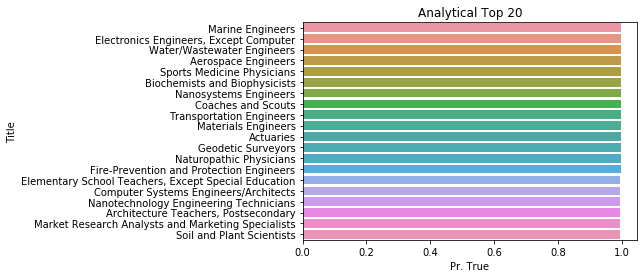

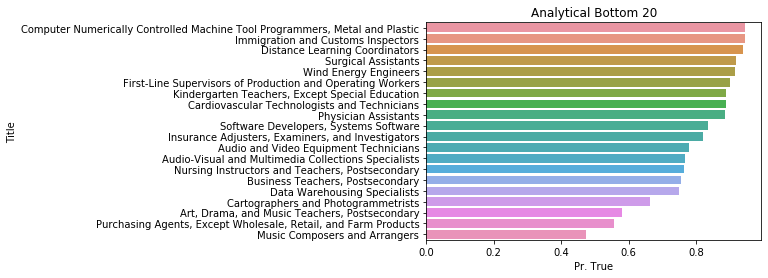

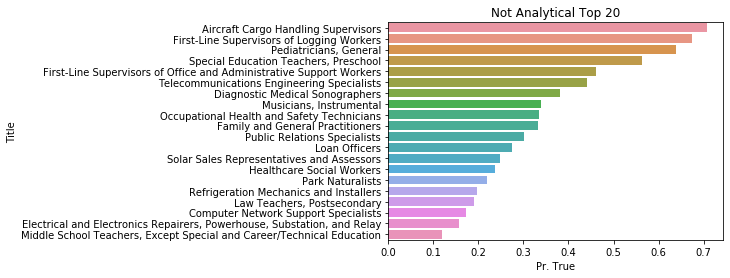

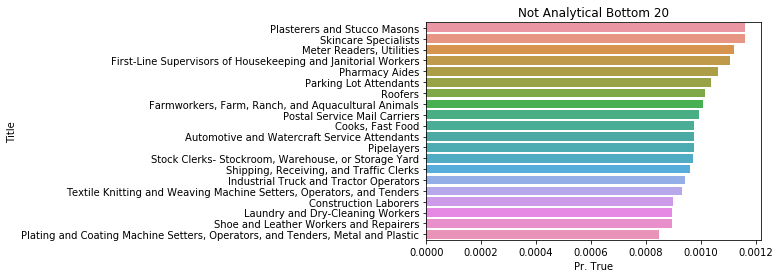

In [0]:
# Visualize results
#import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
#Which occupations are anlytical?
Analytical=final_df[final_df['Analytical']==True]
sns.barplot(x='Pr. True', y='Title', data=Analytical.sort_values('Pr. True', ascending=False).head(20))
plt.title('Analytical Top 20')
plt.show()
sns.barplot(x='Pr. True', y='Title', data=Analytical.sort_values('Pr. True', ascending=False).tail(20))
plt.title('Analytical Bottom 20')
plt.show()
#Which occupations are not analytical?
Not_analytical=final_df[final_df['Analytical']==False]
sns.barplot(x='Pr. True', y='Title', data=Not_analytical.sort_values('Pr. True', ascending=False).head(20))
plt.title('Not Analytical Top 20')
plt.show()
sns.barplot(x='Pr. True', y='Title', data=Not_analytical.sort_values('Pr. True', ascending=False).tail(20))
plt.title('Not Analytical Bottom 20')
plt.show()

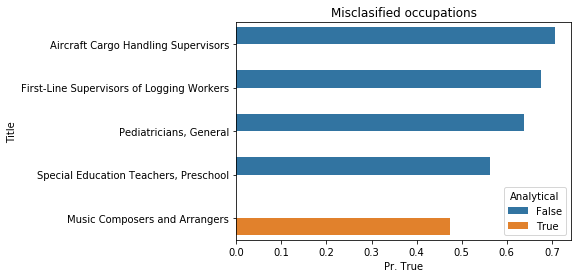

In [0]:
#misclasified occupation
misclasified=final_df[final_df['Analytical']!=final_df['Pr. Analytical']]
sns.barplot(x='Pr. True', y='Title', data=misclasified.sort_values('Pr. True', ascending=False).tail(20), hue='Analytical')
plt.title('Misclasified occupations')
plt.show()